# Оценка результатов A/B-тестирования

**Цель исследования**

Наша задача — провести оценку результатов A/B-теста. В распоряжении есть датасет с действиями пользователей, техническое задание и несколько вспомогательных датасетов.

- Необходимо оценить корректность проведения теста
- Проанализировать результаты теста

Чтобы оценить корректность проведения теста, проверить:  

- пересечение тестовой аудитории с конкурирующим тестом;
- совпадение теста и маркетинговых событий, другие проблемы временных границ теста.

**Техническое задание**

* Название теста: `recommender_system_test`;
* группы: А — контрольная, B — новая платёжная воронка;
* дата запуска: 2020-12-07;
* дата остановки набора новых пользователей: 2020-12-21;
* дата остановки: 2021-01-04;
* аудитория: 15% новых пользователей из региона EU;
* назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
* ожидаемое количество участников теста: 6000.
* ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    * конверсии в просмотр карточек товаров — событие `product_page`,
    * просмотры корзины — `product_cart`,
    * покупки — `purchase`.

**Декомпозиция**  

1. Предобработка данных:
    * Требуется ли преобразование типов?
    * Описать природу пропущенных значений и дубликатов, если их обнаружим.  


2. Оценка корректности проведения теста. Обратить внимание на:
    * Соответствие данных требованиям технического задания. Проверить корректность всех пунктов технического задания.
    * Время проведения теста. Убедиться, что оно не совпадает с маркетинговыми и другими активностями.
    * Аудиторию теста. Удостовериться, что нет пересечений с конкурирующим тестом и нет пользователей, участвующих в двух группах теста одновременно. Проверить равномерность распределения по тестовым группам и правильность их формирования.  
    
    
3. Исследовательский анализ данных и ответы на вопросы:
    * Количество событий на пользователя одинаково распределены в выборках?
    * Как число событий в выборках распределено по дням?
    * Как меняется конверсия в воронке в выборках на разных этапах?
    * Какие особенности данных нужно учесть, прежде чем приступать к A/B-тестированию?  
    
    
4. Оценка результата A/B-тестирования
    * Что можно сказать про результаты A/В-тестирования?
    * Проверить статистическую разницу долей z-критерием.  
    
    
5. Выводы по этапу исследовательского анализа данных и по проведённой оценке результатов A/B-тестирования    Сделать общее заключение о корректности проведения теста.

**Для начала импортируем нужные библиотеки и загрузим датасеты**

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import math as mth
import datetime as dt
import plotly.express as px
from plotly import graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

In [2]:
try:
    marketing_events = pd.read_csv('ab_project_marketing_events.csv')
except:
    marketing_events = pd.read_csv('/Users/alekseivlasov/Desktop/project/13/ab_project_marketing_events.csv')

try:
    new_users = pd.read_csv('final_ab_new_users.csv')
except:
    new_users = pd.read_csv('/Users/alekseivlasov/Desktop/project/13/final_ab_new_users.csv')
    
try:
    ab_events = pd.read_csv('final_ab_events.csv')
except:
    ab_events = pd.read_csv('/Users/alekseivlasov/Desktop/project/13/final_ab_events.csv')
    
try:
    ab_participants = pd.read_csv('final_ab_participants.csv')
except:
    ab_participants = pd.read_csv('/Users/alekseivlasov/Desktop/project/13/final_ab_participants.csv')


## Предобработка данных

In [3]:
marketing_events.head()

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


In [4]:
#Посмотрим общую информацию по первому датасету 
marketing_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


Первый датасет состоит из 4 колонок и 14 строк, пропусков нет, но нужно поменять тип данных в последних двух колонках

In [5]:
marketing_events['start_dt'] = pd.to_datetime(marketing_events['start_dt'])
marketing_events['finish_dt'] = pd.to_datetime(marketing_events['finish_dt'])

In [6]:
#Проверим данные на дубли
marketing_events.duplicated().sum()

0

Поменяли тип данных на временной и проверили датасет на дубли - их не обнаружено

In [7]:
#Следующий датасет
new_users.head()

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


In [8]:
new_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


Датасет состоит из 4 колонок и 61 733 строк, также нет пропусков и нужно поменять тип данных

In [9]:
new_users['first_date'] = pd.to_datetime(new_users['first_date'])

In [10]:
#Проверим на дубли
new_users.duplicated().sum()

0

Поменяли тип данных, дублей нет

In [11]:
#Третий датасет
ab_events.head()

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


In [12]:
ab_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


В датасете 4 колонки и 440 317 строк. Нужно поменять тип данных в ``event_dt`` и в последней колонке у нас есть пропущенные значения, их нужно обработать и понять природу появления

In [13]:
ab_events['event_dt'] = pd.to_datetime(ab_events['event_dt'])

Последняя колонка называется ``Детали``, значит она дополняет другие значения, просмотрим колонку ``event_name``

In [14]:
ab_events['event_name'].value_counts()

login           189552
product_page    125563
purchase         62740
product_cart     62462
Name: event_name, dtype: int64

Мы видим, что количество значений покупок совпадает с данными, которые у нас есть в ``details``  
Скорей всего в ней прописывается сумма покупки, а в других действиях ничего нет  
Поставим на месте пропуска заглушку, так как заполнять будет некорректно 

In [15]:
ab_events['details'] = ab_events['details'].fillna(value = 0)
ab_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     440317 non-null  object        
 1   event_dt    440317 non-null  datetime64[ns]
 2   event_name  440317 non-null  object        
 3   details     440317 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 13.4+ MB


In [16]:
#Проверим на дубли
ab_events.duplicated().sum()

0

In [17]:
#Смотрим последний датасет
ab_participants.head()

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


In [18]:
ab_participants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


В датасете 3 колонки и 18 268 строк, пропусков нет, тип данных указан правильно, осталось проверить на дубли

In [19]:
ab_participants.duplicated().sum()

0

**Вывод:**  
* Провели предобработку данных
* Просмотрели общую информацию по датасетам
* Проверили их на пропуски и дубли, обнаруженные пропуски устранили
* Поменяли тип данных на правильный

Данные готовы к дальнейшему анализу

## Оценка корректности проведения теста

Проверим соответствие данных требованиям технического задания и корректность всех пунктов

In [20]:
ab_participants['ab_test'].value_counts()

interface_eu_test          11567
recommender_system_test     6701
Name: ab_test, dtype: int64

Мы видим, что в датасете присутствует 2 теста, хотя в ТЗ мы анализируем 1

In [21]:
i_1 = ab_participants.groupby(by = ['ab_test', 'group'])['user_id'].count().reset_index()
i_1

,ab_test,group,user_id
0,interface_eu_test,A,5831
1,interface_eu_test,B,5736
2,recommender_system_test,A,3824
3,recommender_system_test,B,2877


По каждому тесту видим по 2 группы: А и В  

Посмотрим, есть ли пользователи, которые учавствуют в дух тестах

In [22]:
#Уникальные пользователи по нашему тесту
a = ab_participants.query('ab_test == "recommender_system_test"')['user_id'].unique()

In [23]:
#Уникальные пользователи по другому тесту
b = ab_participants.query('ab_test == "interface_eu_test"')['user_id'].unique()

In [24]:
#Всего уникальных пользователей в датасете
a_b = ab_participants['user_id'].nunique()

In [25]:
a_b - (len(a)+len(b))

-1602

Есть пользователи, которые попали под основной тест и конкурирующий. Посмотрим, как они распределенны в ``interface_eu_test``

In [26]:
#Соберем список из уникальных пользователей, которые пересекаются
list_users = ab_participants.query('user_id in @a and user_id in @b')['user_id'].unique()

In [27]:
i_2 = (
 ab_participants.query('user_id in @list_users and ab_test == "interface_eu_test"')
    .groupby('group', as_index=False)
    .agg({'user_id':'nunique'})
)
i_2

,group,user_id
0,A,819
1,B,783


In [28]:
#Посчитаем доли:
print('Доля пользователей группы А:', round(i_2['user_id'][0]/i_1['user_id'][0], 2))
print('Доля пользователей группы В:', round(i_2['user_id'][1]/i_1['user_id'][1], 2))

Доля пользователей группы А: 0.14
Доля пользователей группы В: 0.14


Доли пользователей распределены равномерно между группами ``A`` и ``B`` в тесте ``interface_eu_test``, можно сделать вывод, что он оказал на них одинаковое влияние  
**Вывод:** 1602 пользователя оставляем, убираем пользовтелей, которые к нашему тесту не относятся

In [29]:
ab_participants = ab_participants.query('ab_test == "recommender_system_test"')
ab_participants.shape

(6701, 3)

Проверим дату запуска теста

In [30]:
ab_events['event_dt'].min()

Timestamp('2020-12-07 00:00:33')

Дата запуска верна

В ТЗ указано, что дата остановки набора новых пользователей: 2020-12-21

In [31]:
new_users['first_date'].max()

Timestamp('2020-12-23 00:00:00')

Мы видим, что пользователи приходили после 21 декабря, их мы уберем

In [32]:
new_users = new_users.query('first_date < "2020-12-22"')
new_users['first_date'].max()

Timestamp('2020-12-21 00:00:00')

Дата остановки теста: 2021-01-04

In [33]:
ab_events['event_dt'].max()

Timestamp('2020-12-30 23:36:33')

Нам в данных не хватает 5 дней, либо мы подглядываем, что не хорошо, либо нам дали не все данные  
5 дней - это 18% от всего времени, которое планировалось на проведение А/B теста  
Это нужно учитывать, при результатах теста

У нас должна быть аудитория: 15% новых пользователей из региона EU  
Проверим

In [34]:
#Для начала объединим 3 датасета
df_oll = new_users.merge(ab_participants, on='user_id', how='right')
df_oll = df_oll.merge(ab_events, on='user_id', how='left')
df_oll.head()

,user_id,first_date,region,device,group,ab_test,event_dt,event_name,details
0,D1ABA3E2887B6A73,2020-12-07,EU,PC,A,recommender_system_test,2020-12-07 14:43:27,purchase,99.99
1,D1ABA3E2887B6A73,2020-12-07,EU,PC,A,recommender_system_test,2020-12-25 00:04:56,purchase,4.99
2,D1ABA3E2887B6A73,2020-12-07,EU,PC,A,recommender_system_test,2020-12-07 14:43:29,product_cart,0.00
3,D1ABA3E2887B6A73,2020-12-07,EU,PC,A,recommender_system_test,2020-12-25 00:04:57,product_cart,0.00
4,D1ABA3E2887B6A73,2020-12-07,EU,PC,A,recommender_system_test,2020-12-07 14:43:27,product_page,0.00


In [35]:
oll_EU = new_users.query('region == "EU"')['user_id'].nunique()
oll_EU

42340

In [36]:
test_EU = df_oll.query('region == "EU"')['user_id'].nunique()
test_EU

6351

In [37]:
print('Процент пользователей из региона EU:', round((test_EU/oll_EU)* 100),'%')

Процент пользователей из региона EU: 15 %


In [38]:
print('Количество участников теста получается:', df_oll['user_id'].nunique())

Количество участников теста получается: 6701


Проверим, не было ли за время теста 2020-12-07 - 2021-01-04 маркетинговых активностей

In [39]:
marketing_events.query('"2020-12-07" <= start_dt <= "2021-01-04"')

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07


У нас есть 2 промо, второй нам не страшен, так как у нас после 30 декабря нет данных, а первый попадает на 5 дней теста, это значительный объем, поэтому не будем его убирать  
Будем держать ``Christmas & New Year Promo`` в голове

У нас тест закончился 30 декабря, нам надо отфильтровать пользователей, у кого меньше 14 дней  

In [40]:
df_oll['event_date_count'] = (df_oll['event_dt'] - df_oll['first_date']).dt.days
df_oll = df_oll.query('event_date_count <= 14')
warnings.filterwarnings('ignore')
df_oll.head()

,user_id,first_date,region,device,group,ab_test,event_dt,event_name,details,event_date_count
0,D1ABA3E2887B6A73,2020-12-07,EU,PC,A,recommender_system_test,2020-12-07 14:43:27,purchase,99.99,0.0
2,D1ABA3E2887B6A73,2020-12-07,EU,PC,A,recommender_system_test,2020-12-07 14:43:29,product_cart,0.00,0.0
4,D1ABA3E2887B6A73,2020-12-07,EU,PC,A,recommender_system_test,2020-12-07 14:43:27,product_page,0.00,0.0
6,D1ABA3E2887B6A73,2020-12-07,EU,PC,A,recommender_system_test,2020-12-07 14:43:27,login,0.00,0.0
8,A7A3664BD6242119,2020-12-20,EU,iPhone,A,recommender_system_test,2020-12-20 15:46:06,product_page,0.00,0.0


## Исследовательский анализ данных

Посмотрим распределение событий по датам и группам

Выделим дату из временного столбца ``event_dt``

In [41]:
df_oll['event_dt'] = df_oll['event_dt'].dt.date
df_oll['event_dt'] = pd.to_datetime(df_oll['event_dt'])

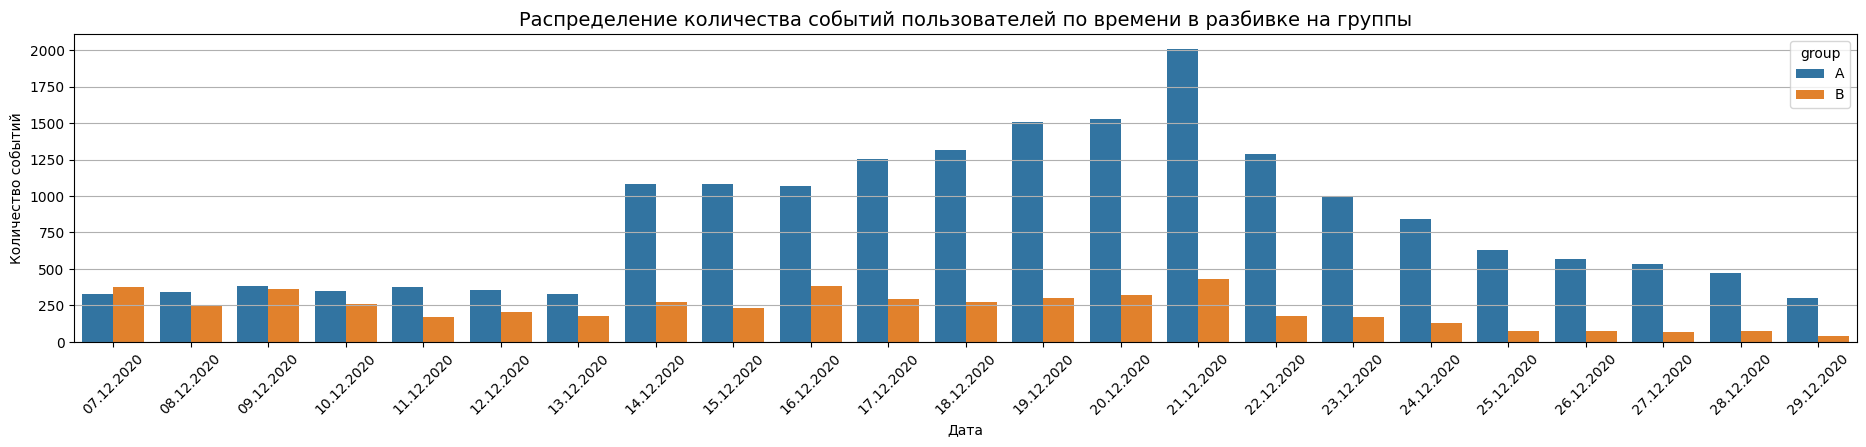

In [42]:
plot=df_oll.groupby(['event_dt', 'group'])['user_id'].count().reset_index()
plot.index = plot['event_dt']

plt.figure(figsize = (23, 4))
plt.grid(True)
plt.title('Распределение количества событий пользователей по времени в разбивке на группы', size=14)
sns.barplot(data = plot, x = plot.index.strftime('%d.%m.%Y'), y = 'user_id', hue = 'group')
plt.ylabel('Количество событий')
plt.xlabel('Дата')
plt.xticks(rotation = 45)
plt.show()

И посмотрим распределение событий по тестовым группам

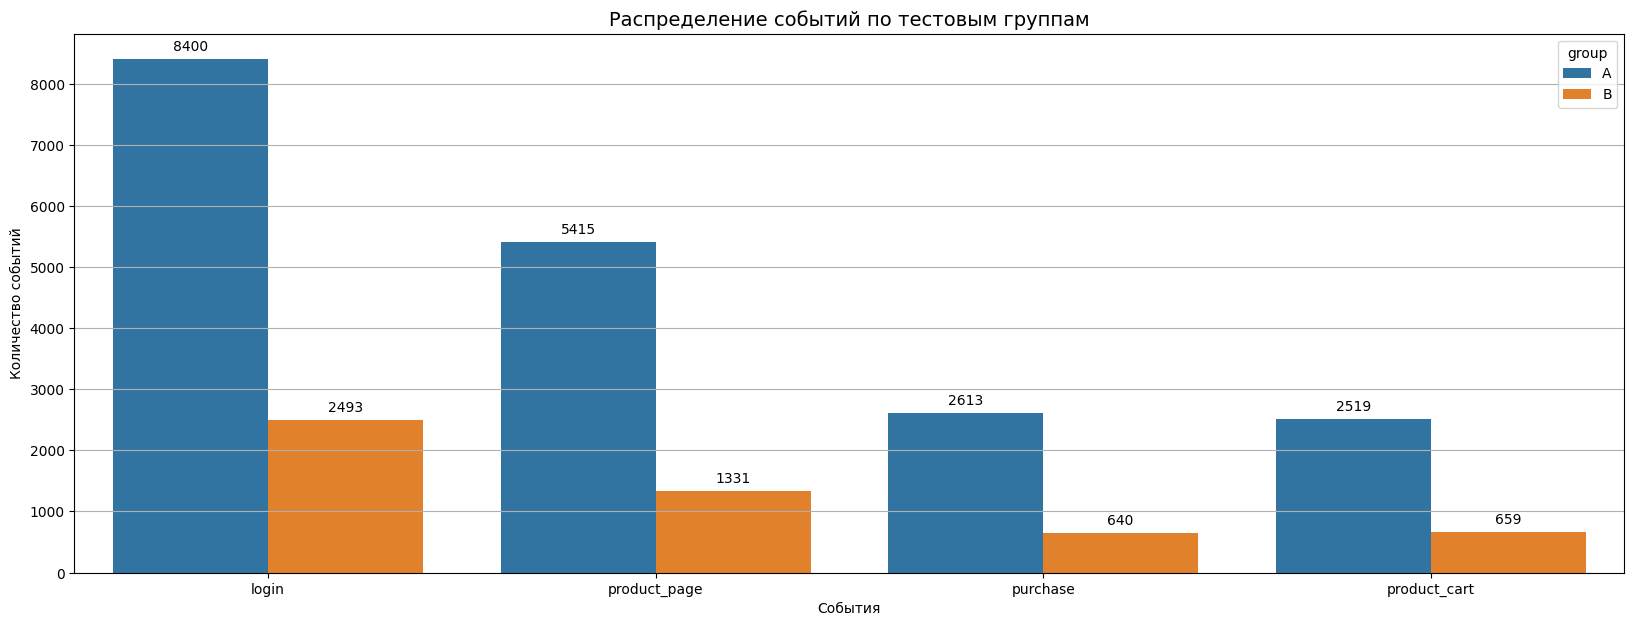

In [43]:
plt.figure(figsize = (20, 7))
plt.grid(True)
plt.title('Распределение событий по тестовым группам', size=14)
plot = (
    sns.countplot(data = df_oll, x = 'event_name', hue = 'group', order = df_oll['event_name'].value_counts().index)
)
for p in plot.patches:
    plot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.ylabel('Количество событий')
plt.xlabel('События')
plt.show()

Проверим, что количество событий на пользователя одинаково распределены в выборках

In [44]:
#Отфильтруем данные

events_date = (
    df_oll.groupby(['event_dt', 'group']).agg({'user_id' : 'nunique','event_name' : 'count'}).reset_index()
)
events_date['mean'] = events_date['event_name'] / events_date['user_id']
events_date.head()

,event_dt,group,user_id,event_name,mean
0,2020-12-07,A,154,331,2.149351
1,2020-12-07,B,173,378,2.184971
2,2020-12-08,A,160,341,2.131250
3,2020-12-08,B,120,252,2.100000
4,2020-12-09,A,178,385,2.162921


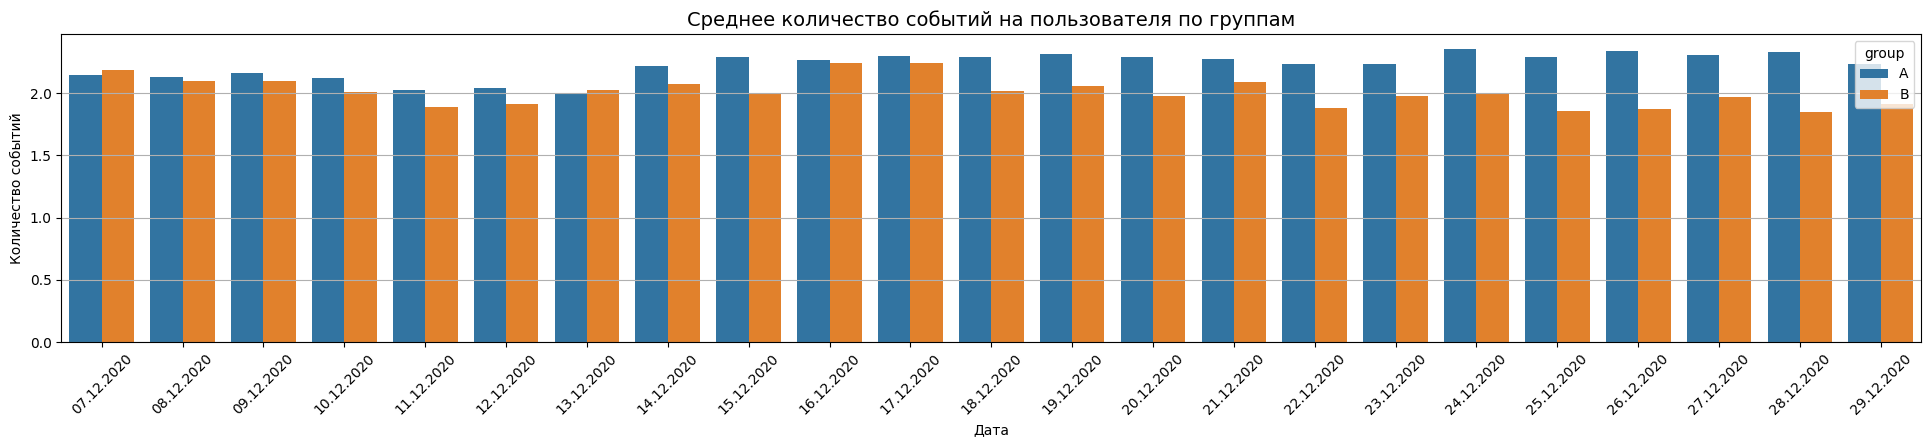

In [45]:
#Нарисуем график

events_date.index = events_date['event_dt']

plt.figure(figsize = (24, 4))
plt.grid(True)
plt.title('Среднее количество событий на пользователя по группам', size=14)
sns.barplot(data = events_date, x = events_date.index.strftime('%d.%m.%Y'), y = 'mean', hue = 'group')
plt.ylabel('Количество событий')
plt.xlabel('Дата')
plt.xticks(rotation = 45)
plt.show()

Мы видим, что группа ``А`` лидирует почти каждый день  
В среднем, пользователь совершает за день 2 действия


**Посмотрим, как число событий в выборках распределено по дням**

In [46]:
df_oll['event_name'].isna().sum()

0

В ``event_name`` есть пропуски, скорей всего пользователи не совершали событий, мы поставим загрушку

In [47]:
df_oll['event_name'] = df_oll['event_name'].fillna(value = 'unknown')
df_oll['event_name'].value_counts()

login           10893
product_page     6746
purchase         3253
product_cart     3178
Name: event_name, dtype: int64

In [48]:
count_events_per_day = df_oll.query('event_name != "unknown"')
count_events_per_day['date'] = count_events_per_day['event_dt'].dt.day

#Группа А
count_events_per_day_A = (
    count_events_per_day.query('group == "A"')
    .pivot_table(index=['event_name','date'], values='event_dt', aggfunc='count').reset_index()
)
count_events_per_day_A.columns = ['event_name', 'date', 'count_event']

#Группа В
count_events_per_day_B = (
    count_events_per_day.query('group == "B"')
    .pivot_table(index=['event_name','date'], values='event_dt', aggfunc='count').reset_index()
)
count_events_per_day_B.columns = ['event_name', 'date', 'count_event']

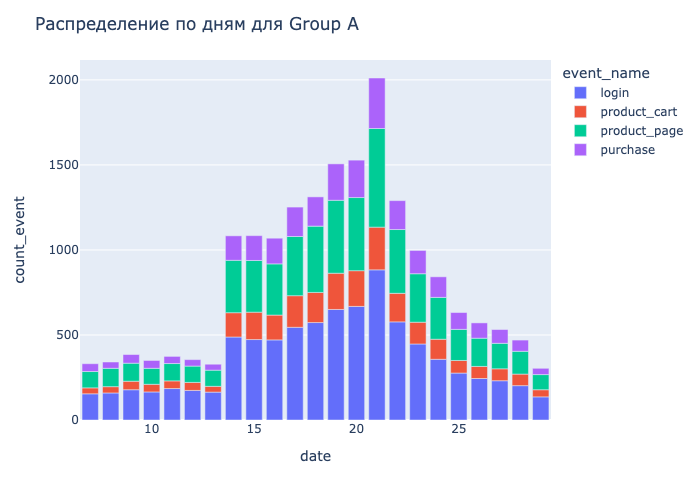

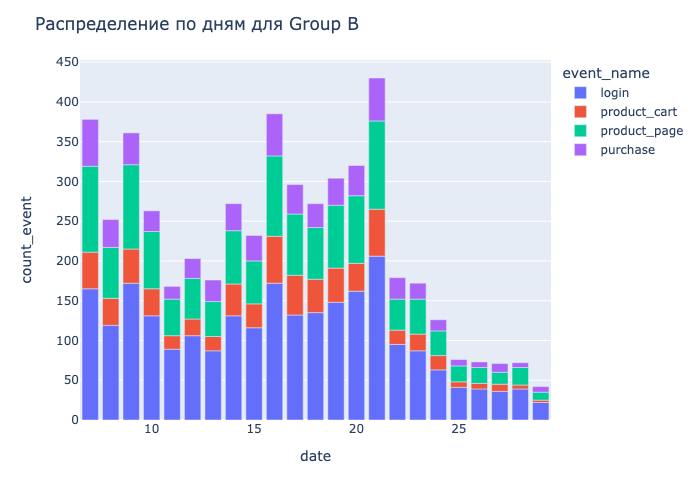

In [49]:
figA = px.bar(count_events_per_day_A, x='date', y='count_event', color='event_name')
figA.update_layout(title='Распределение по дням для Group A')
figA.show('png')

figB = px.bar(count_events_per_day_B, x='date', y='count_event', color='event_name')
figB.update_layout(title='Распределение по дням для Group В')
figB.show('png')

* В обеих группах пиковая активность пользователей достигнута 21 числа

* В группе ``В`` наблюдается высокая активность 7, 9 и 16 числа, максимальное число покупок за это период пользователи совершили 7 числа, было совершено 59 покупок  

* В группе ``А`` максимальное значение покупок совпадает с пиковым значением по сумме всех событий, за 21 число было совершено 297 покупок  

* Схожесть распределения событий по дням начинается с 22 числа, наблюдается плавный спад активность у группы ``А`` и менее плавный спад у группы ``В``  

* Активность пользователей не коррелирует с маркетинговыми мероприятиями проведенными в эти даты, есть два события Christmas&New Year Promo начало 25 числа и CIS New Year Gift Lottery начало 30 числа.

**Мы изучили количество событий по каждой группе, теперь проанализируем, как менялась конверсия в воронке в выборках на разных этапах**

Соберем 2 группы

In [50]:
fun_a = df_oll.query('group == "A"')\
                .groupby('event_name')['user_id'].nunique().reset_index().sort_values('user_id', ascending = False)
fun_a = fun_a.reindex([0,2,1,3])
fun_b = df_oll.query('group == "B"')\
                .groupby('event_name')['user_id'].nunique().reset_index().sort_values('user_id', ascending = False)
fun_b = fun_b.reindex([0,2,1,3])

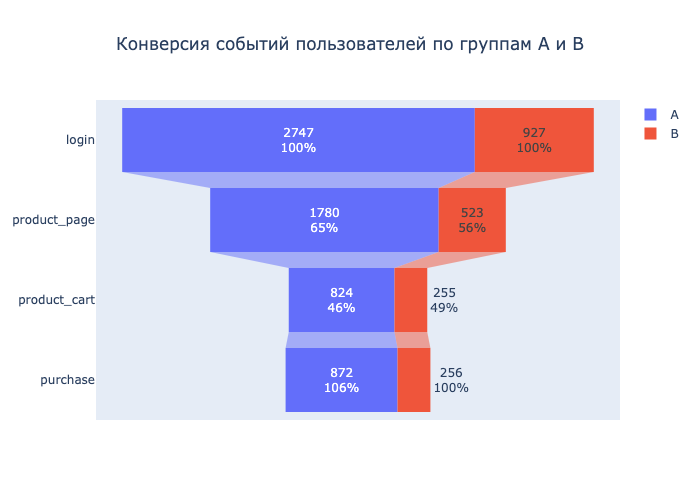

In [51]:
fig = go.Figure()

fig.add_trace(go.Funnel(
    name = 'A',
    y = fun_a['event_name'],
    x = fun_a['user_id'],
    textinfo = "value+percent previous"))

fig.add_trace(go.Funnel(
    name = 'B',
    y = fun_b['event_name'],
    x = fun_b['user_id'],
    textinfo = "value+percent previous"))

fig.update_layout(
    title = {
        'text' : 'Конверсия событий пользователей по группам А и В',
        'x':0.5
    }
)

fig.show('png')

* Дойдя до страницы ``product_card``, все пользователи производят оплату, в группе ``В`` это 100%, в группе ``А`` - 106%, что говорит о том, что можно оплачивать минуя корзину

* Конверсия в группе ``A`` выше на этапах: product_page и purchase. Группа ``B`` лидирует только на этапе product_cart
* Ожидаемый эффект лучшей конверссии группы ``В`` в размере прироста на 10% не наблюдается

**Какие особенности данных нужно учесть, прежде чем приступать к A/B-тестированию**

1.  Группа ``A`` больше почти на 1000 пользователей группы ``B``  
2.  1602 пользователя учавствовали в конкурирующем A/B-тесте
3.  Нам в данных не хватает 5 дней, либо мы подглядываем, что не хорошо, либо нам дали не все данные
4.  В момент тестирования были запущены 2 маркетинговые активности

## Оценка результата A/B-тестирования

Что можно сказать про результаты A/В-тестирования:  
Мы видим в воронке, что не произошел рост на 10%, а даже немного произошел спад по конверсиям

Посмотрим на количество пользователей в каждой экспериментальной группе в разрезе событий:

In [52]:
events_by_groups = df_oll\
                    .pivot_table(index = 'event_name', columns = 'group', values = 'user_id', aggfunc = 'nunique')\
                    .sort_values('A', ascending = False)

events_by_groups

group,A,B
event_name,,
login,2747,927
product_page,1780,523
purchase,872,256
product_cart,824,255


Размеры групп различаются, что говорит о неоптимальности разбиения данных по группам

**Нулевая гипотеза:** Группы А и В равны  
**Альтернативная гипотеза:** Между группами есть разница

**Проверим статистическую разницу долей z-критерием**

In [53]:
#Напишем функцию

def z_test(group_1, group_2, eventname, alpha): 
    purchases1 = events_by_groups.loc[eventname, group_1]
    purchases2 = events_by_groups.loc[eventname, group_2]
    n1 = events_by_groups.iloc[0, 0]
    n2 = events_by_groups.iloc[0, 1]
    p1 = purchases1 / n1    
    p2 = purchases2 / n2     
    difference = p1 - p2    
    p_combined = (purchases1 + purchases2) / (n1 + n2)    
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1 / n1 + 1 / n2))                
    distr = st.norm(0, 1)    
    p_value = (1 - distr.cdf(abs(z_value))) * 2

    bonferroni_alpha = alpha / 4
    
    print('Проверка события:', eventname)
    print('p-value: ',p_value)
   
    if (p_value < bonferroni_alpha):
        print("Отвергаем нулевую гипотезу: между конверсией групп есть значимая разница")
    else:
        print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсию групп разной") 
    print('')

In [54]:
for eventname in events_by_groups.index:
    z_test('A', 'B', eventname, 0.05)

Проверка события: login
p-value:  nan
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсию групп разной

Проверка события: product_page
p-value:  5.084368080776613e-06
Отвергаем нулевую гипотезу: между конверсией групп есть значимая разница

Проверка события: purchase
p-value:  0.018474632659979617
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсию групп разной

Проверка события: product_cart
p-value:  0.15034216422194624
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсию групп разной



Для события ``login``, проверка статистической разницы долей z-критерием невозможна, так как это действие совершили все пользователи группы ``А`` и группы ``В``, а это число соответствует максимальному размеру выборки групп.

Значимая статистическая разница в конверсии групп ``А`` и ``В`` присутствует только для события product_page.

## Вывод

Мы завершили исследование и оценку результатов A/B-тестирования

**Предобработка данных:**  
* Просмотрели общую информацию по датасетам
* Проверили их на пропуски и дубли, обнаруженные пропуски устранили
* Поменяли тип данных на правильный  

**Оценка корректности проведения теста:**  
* Группа ``A`` больше почти на 1000 пользователей группы ``B``  
* 1602 пользователя учавствовали в конкурирующем A/B-тесте
* Нам в данных не хватает 5 дней, либо мы подглядываем, что не хорошо, либо нам дали не все данные
* В момент тестирования были запущены 2 маркетинговые активности  

Поэтому доверять результатам исследования не стоит, так как далеко не все правила ТЗ были исполнены

**Исследовательский анализ данных:**  
* В обеих группах пиковая активность пользователей достигнута 21 числа

* В группе ``В`` наблюдается высокая активность 7, 9 и 16 числа, максимальное число покупок за это период пользователи совершили 7 числа, было совершено 59 покупок  

* В группе ``А`` максимальное значение покупок совпадает с пиковым значением по сумме всех событий, за 21 число было совершено 297 покупок  

* Схожесть распределения событий по дням начинается с 22 числа, наблюдается плавный спад активность у группы ``А`` и менее плавный спад у группы ``В``  

* Активность пользователей не коррелирует с маркетинговыми мероприятиями проведенными в эти даты, есть два события Christmas&New Year Promo начало 25 числа и CIS New Year Gift Lottery начало 30 числа.
* Дойдя до страницы ``product_card``, все пользователи производят оплату, в группе ``В`` это 100%, в группе ``А`` - 106%, что говорит о том, что можно оплачивать минуя корзину

* Конверсия в группе ``A`` выше на этапах: product_page и purchase. Группа ``B`` лидирует только на этапе product_cart
* Ожидаемый эффект лучшей конверссии группы ``В`` в размере прироста на 10% не наблюдается

**Оценка результата A/B-тестирования:**  
Для события ``login``, проверка статистической разницы долей z-критерием невозможна, так как это действие совершили все пользователи группы ``А`` и группы ``В``, а это число соответствует максимальному размеру выборки групп  

Значимая статистическая разница в конверсии групп ``А`` и ``В`` присутствует только для события product_page  
Но как показывает конверсия, изменения только ухудшили результаты  
Поэтому оснований считать изменения, связанные с внедрением улучшенной рекомендательной системы, успешными нет  
Лучше остаться на прошлом варианте до изменения или провести A/B тестирование заново, но строго по ТЗ, так как были допущены ошибки